### Bellabeat Marketing Analysis Report
author: Katelyn Mueller<br>
date: 10-05-2023

##### Business Task Summary:

The objective of this analysis is to gain insights into smart device usage trends among consumers and how these trends could be applied to Bellabeat customers. By understanding these trends, my aim is to provide high-level recommendations for how Bellabeat's marketing strategy can be influenced. The analysis will focus on one Bellabeat product, and I will use the gathered insights to guide marketing strategies effectively. 

Key stakeholders in this task include:

* Urška Sršen (Bellabeat Cofounder and Chief Creative Officer)
* Sando Mur (Bellabeat Cofounder and Key Member of the Executive Team)
* Bellabeat Marketing Analytics Team (Data Analysts)

***
#### Prepare

Data source:
Fitbit Fitness Tracker Data - Public Dataset via Kaggle

_This dataset generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016. Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. Variation between output represents use of different types of Fitbit trackers and individual tracking behaviors / preferences._

This dataset is organized into 15 csv files that include data on:

* Activity (daily)
* Calories (daily, hourly, minute [wide + narrow])
* Intensities (daily, hourly, minute [wide + narrow])
* Steps (daily, hourly, minute [wide + narrow])
* Sleep (daily, minute)
* METs (minute [narrow])
* Heartrate (seconds)
* Weight Logs

It will help with understanding real-world usage trends, consumer preferences, and market insights. This data will provide a benchmark against which BellaBeat can measure itself.

**HOWEVER! The Data Does Not ROCCC:**

* **Reliability:** VERY LOW. The sample size of 30 users is quite small, and it may not be representative of the broader population of fitness tracker users. If these users were not selected randomly or if they were volunteers, the data could be subject to selection bias, which means it may not accurately reflect the characteristics and behaviors of all fitness tracker users. There is also a potential demographic bias. If the 30 users in the sample do not represent a diverse range of demographics (e.g., age, geographic location, socioeconomic status), the data could be biased toward a particular group's behaviors and preferences, limiting its applicability to a broader population. Additionally, if any of the 30 users are men, this could affect the usefulness of the data for this specific business analysis, as BellaBeat’s target demographic is women.
* **Original:** LOW. Third party data collected via Amazon Mechanical Turk.
* **Comprehensive:** MEDIUM. Wide range of data collected, spanning activity, intensity, calories, steps, sleep, and weight. Data is also organized in varying levels of granularity, from seconds to days.
* **Current:** LOW. This data was collected between March 2016 and May 2016. Fitness tracker device capabilities have evolved significantly in the seven years since. Using data from that year may not accurately represent how people use fitness trackers today. This could limit the relevance of the insights gained from the data.
* **Cited:** MEDIUM. Third party data collection, but data collector and source is well documented.

In a real-world scenario, this is the point at which I would share my concerns with the stakeholders and seek out clarification and/or alternate dataset options. For the purposes of this case study, my analysis and recommendations are heavily caveated due to the limitations of the available data.

***
#### Process
I first opened the csv files in Excel to examine them. I noticed that dailyActivity included all data from dailyCalories, dailyIntensity, and dailySteps. After using Pivot Tables to verify that the data totals were the same across the individual and aggregated files, I opted not to import those redundant files to BigQuery. I also chose to omit minuteCaloriesWide, minuteIntensitiesWide, and minuteStepsWide from BigQuery, instead focusing on the narrow versions of those datasets.

When importing sleepDay_merged to Google BigQuery, I encountered an error indicating the timezone in one of the columns was invalid.
In order to fix this, I imported the csv in Excel, reformatted the “sleepDay” column to a more suitable Date format, and exported as a new file, which then loaded successfully in BigQuery.

I followed the same procedure with the following files:

* hourlyIntensities_merged
* hourlyCalories_merged
* hourlySteps_merged
* minuteSleep_merged
* weightLogInfo_merged

These files were too large for Excel to fully load, so they required a different approach:

* heartrate_seconds_merged
* minuteCaloriesNarrow_merged
* minuteIntensitiesNarrow_merged
* minuteMETsNarrow_merged
* minuteStepsNarrow_merged

Instead of auto-detecting the schema for these files during import, I manually added the fields and set the date/time column to return a string value. I then transformed the timestamp data in BigQuery as follows:

heartrate_seconds
```
SELECT 
Id,
FORMAT_TIMESTAMP(
  '%Y-%m-%d %H:%M:%S %Z',
  PARSE_TIMESTAMP('%m/%d/%Y %I:%M:%S %p', Time)
) AS Time, Value 
FROM `nifty-catfish-400822.fitbit_data.seconds_heartrate`
```

minuteCalories
```
SELECT
Id,
FORMAT_TIMESTAMP(
  '%Y-%m-%d %H:%M:%S %Z',
  PARSE_TIMESTAMP('%m/%d/%Y %I:%M:%S %p', ActivityMinute)
) AS ActivityMinute, Calories
FROM `nifty-catfish-400822.fitbit_data.minute_calories`
```

minuteIntensities
```
SELECT
Id,
FORMAT_TIMESTAMP(
  '%Y-%m-%d %H:%M:%S %Z',
  PARSE_TIMESTAMP('%m/%d/%Y %I:%M:%S %p', ActivityMinute)
) AS ActivityMinute, Intensity
FROM `nifty-catfish-400822.fitbit_data.minute_intensities`
```

minuteMETs
```
SELECT
Id,
FORMAT_TIMESTAMP(
  '%Y-%m-%d %H:%M:%S %Z',
  PARSE_TIMESTAMP('%m/%d/%Y %I:%M:%S %p', ActivityMinute)
) AS ActivityMinute, METs
 FROM `nifty-catfish-400822.fitbit_data.minute_METs`
```

minuteSteps
```
SELECT
Id,
FORMAT_TIMESTAMP(
  '%Y-%m-%d %H:%M:%S %Z',
  PARSE_TIMESTAMP('%m/%d/%Y %I:%M:%S %p', ActivityMinute)
) AS ActivityMinute, Steps
FROM `nifty-catfish-400822.fitbit_data.minute_steps`
```

I exported the results of each query as a new BigQuery table appended with “_corrected”, and then deleted the old tables from the project to remove clutter and redundancy.

***
#### Analyze
I first confirmed that each table in my dataset contains the Id column:
```
SELECT
table_name,
SUM(CASE
WHEN column_name = "Id" THEN 1
ELSE
0
END
) AS has_id_column
FROM
`nifty-catfish-400822.fitbit_data.INFORMATION_SCHEMA.COLUMNS`
GROUP BY
1
ORDER BY
1 ASC
```

And then used this query to confirm that the date/time fields were all imported and transformed properly (this query should bring up an empty table when that is the case)
```
SELECT
table_name,
SUM(CASE
WHEN data_type IN ("TIMESTAMP", "DATETIME", "TIME", "DATE") THEN 1
ELSE
0
END
) AS has_time_info
FROM
`nifty-catfish-400822.fitbit_data.INFORMATION_SCHEMA.COLUMNS`
WHERE
data_type IN ("TIMESTAMP",
"DATETIME",
"DATE")
GROUP BY
1
HAVING
has_time_info = 0;
```

I analyzed the different tables to see how many distinct users contributed each type of data. There were 33 unique users for most data categories. The exceptions were sleep (24 users), heartrate (14 users), and weight (8 users).

Sample SQL queries:
```
SELECT
  COUNT(DISTINCT(Id))
FROM
`nifty-catfish-400822.fitbit_data.daily_activity`
```

```
SELECT
  COUNT(DISTINCT(Id))
FROM
`nifty-catfish-400822.fitbit_data.daily_sleep`
```

```
SELECT
  COUNT(DISTINCT(Id))
FROM
`nifty-catfish-400822.fitbit_data.seconds_heartrate_corrected`
```

```
SELECT
  COUNT(DISTINCT(Id))
FROM
`nifty-catfish-400822.fitbit_data.weight_log`
```

Next I compared the sums of the same data types across the different tables (daily steps, hourly steps, steps by minute, etc). Unfortunately, I found discrepancies across all of the data.

```
SELECT
  SUM(TotalSteps)
FROM
`nifty-catfish-400822.fitbit_data.daily_activity`
```

```
SELECT
  SUM(StepTotal)
FROM
`nifty-catfish-400822.fitbit_data.hourly_steps`
```

```
SELECT
  SUM(Steps)
FROM
`nifty-catfish-400822.fitbit_data.minute_steps_corrected`
```

```
SELECT
  SUM(Calories)
FROM
`nifty-catfish-400822.fitbit_data.daily_activity`
```

```
SELECT
  SUM(Calories)
FROM
`nifty-catfish-400822.fitbit_data.hourly_calories`
```

```
SELECT
  SUM(Calories)
FROM
`nifty-catfish-400822.fitbit_data.minute_calories_corrected`
```

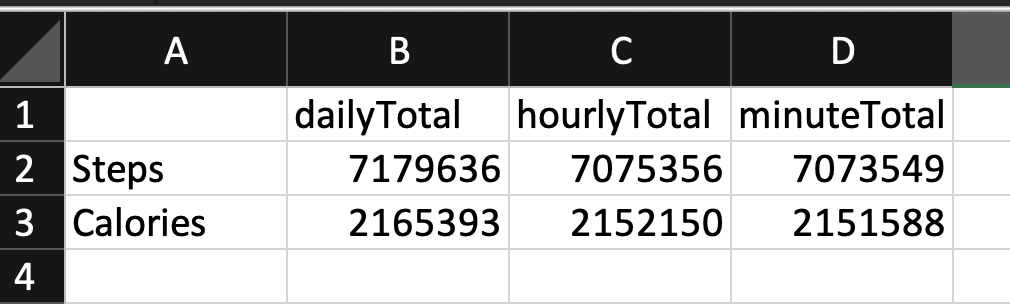

For this reason, in order to make the cleanest comparisons possible, I opted to limit the remainder of my analysis to the daily data.

I then performed a left join on the daily activity and daily sleep tables:

```
SELECT
  *
FROM
`nifty-catfish-400822.fitbit_data.daily_activity` AS activity
LEFT JOIN
`nifty-catfish-400822.fitbit_data.daily_sleep` AS sleep
ON
activity.Id = sleep.Id
AND activity.ActivityDate = sleep.SleepDay
```

And saved the results in a new BigQuery table titled activity_sleep_merged

I then used the following queries to look at steps, activity and sleep trends on a per-user basis:

```
SELECT 
  DISTINCT(Id) AS UniqueUser,
  ROUND(AVG(TotalSteps)) AS AvgStepsByUser,
  MIN(TotalSteps) AS MinSteps,
  MAX(TotalSteps) AS MaxSteps,
  ROUND(AVG(TotalMinutesAsleep)) AS AvgSleepByUser
   FROM `nifty-catfish-400822.fitbit_data.activity_sleep_merged`
WHERE
  TotalSleepRecords > 0
GROUP BY
  Id
ORDER BY
  Id
```

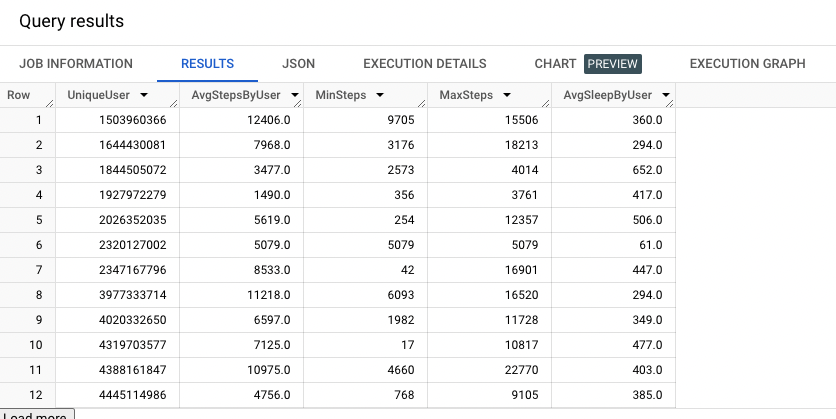

```
SELECT 
  DISTINCT(Id) AS UniqueUser,
  ROUND(AVG(VeryActiveMinutes)) AS AvgVeryActive,
  ROUND(AVG(FairlyActiveMinutes)) AS AvgFairlyActive,
  ROUND(AVG(LightlyActiveMinutes)) AS AvgLightlyActive,
  ROUND(AVG(SedentaryMinutes)) AS AvgSedentary,
  ROUND(AVG(TotalMinutesAsleep)) AS AvgSleepByUser
   FROM `nifty-catfish-400822.fitbit_data.activity_sleep_merged`
WHERE
  TotalSleepRecords > 0
GROUP BY
  Id
ORDER BY
  Id
```
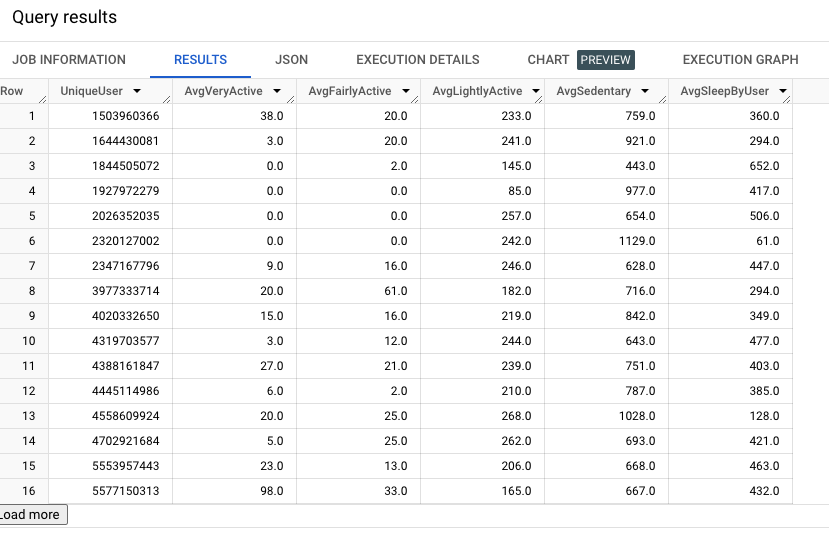

```
SELECT 
  DISTINCT(Id) AS UniqueUser,
    SUM(VeryActiveMinutes) + SUM(FairlyActiveMinutes) + SUM(LightlyActiveMinutes) AS AvgActiveAll
   FROM `nifty-catfish-400822.fitbit_data.activity_sleep_merged`
WHERE
  TotalSleepRecords > 0
GROUP BY
  Id
ORDER BY
  Id
```
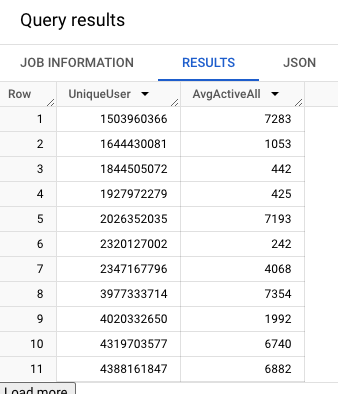

Finally, I used the following query to analyze heartrate data per user:

```
SELECT 
  DISTINCT(Id) AS UniqueUser,
  MIN(Value) AS MinHeartrate,
  MAX(Value) AS MaxHeartrate,
  ROUND(AVG(Value)) AS AvgHeartrate
FROM `nifty-catfish-400822.fitbit_data.seconds_heartrate_corrected`
GROUP BY
  Id
ORDER BY
  Id
```
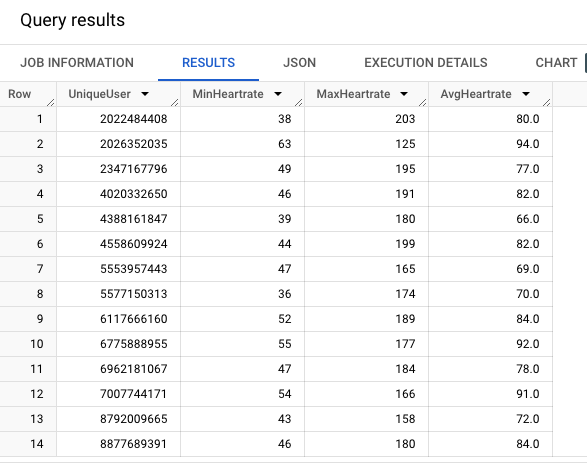

***
#### Share
I used Tableau to create visualizations of my analysis.

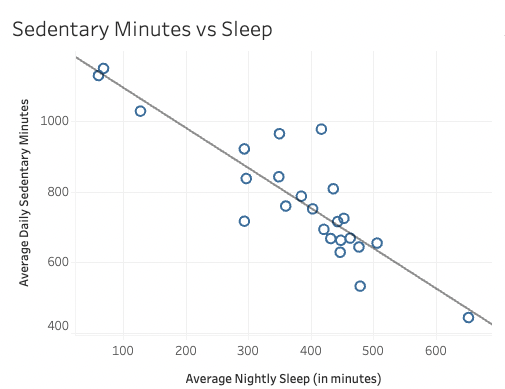

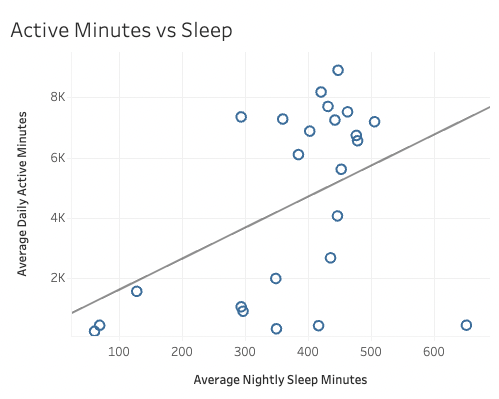

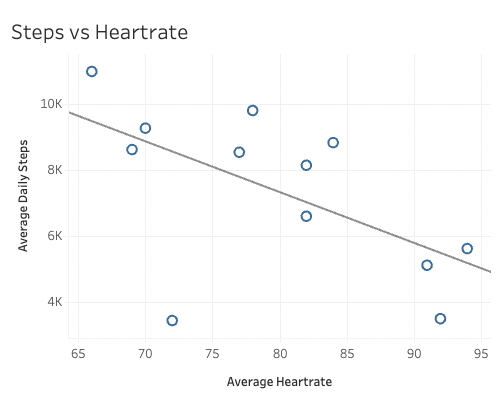

Key findings:
* There was a strong negative correlation between average sedentary minutes and average nightly sleep.
* There was a moderate positive correlation between average number of active minutes (sum of light, fairly, very) and average nightly sleep.
* There was a moderate negative correlation between average daily steps and average heartrate.

***
#### Act
Based on my analysis, here are my recommendations to the stakeholders:
* Have the Bellabeat app send users a push notification after an extended sedentary (non-sleeping) period.
* Incorporate challenges and rewards into the Bellabeat app to incentivize users to be more active during the day
* Collect first-party Bellabeat user data to repeat this analysis and confirm these findings. Extend further analysis to data on mindfulness, hydration, and menstruation.